In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 0.25 # Time step [day]

In [92]:
permafrost = '/content/drive/My Drive/Colab Notebooks/PermafrostTemperatureScenarios.csv'
data = np.loadtxt(permafrost, delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

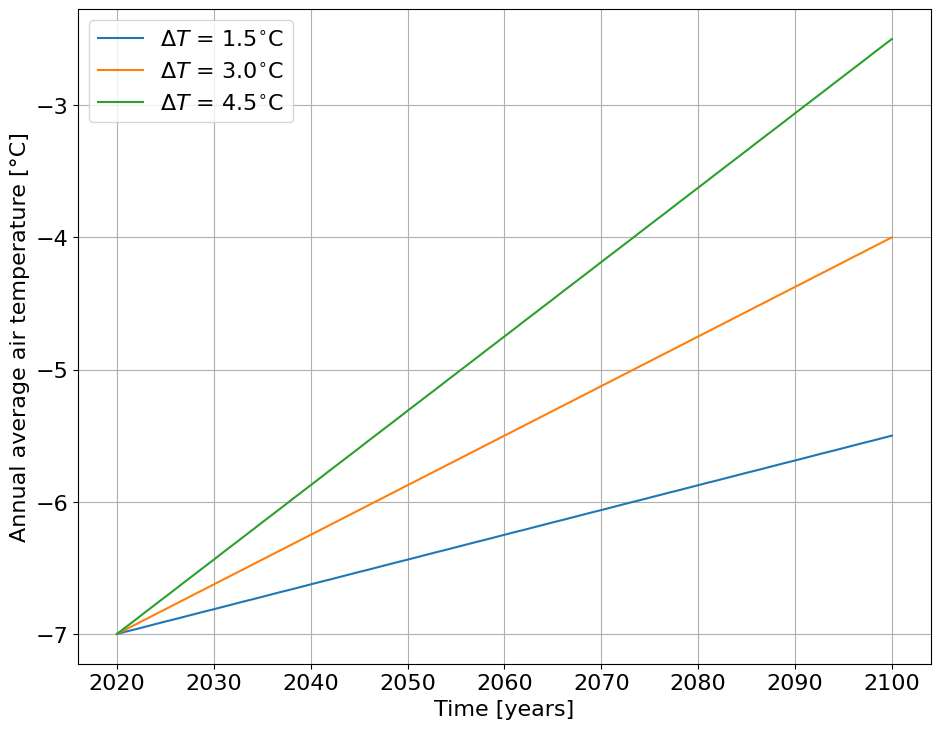

In [79]:
# First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

In [93]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


In [94]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

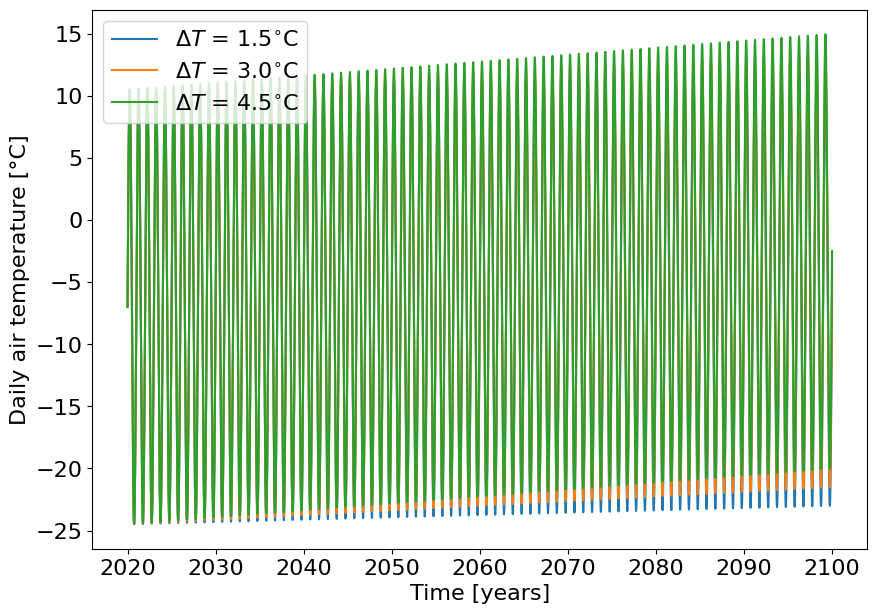

In [95]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

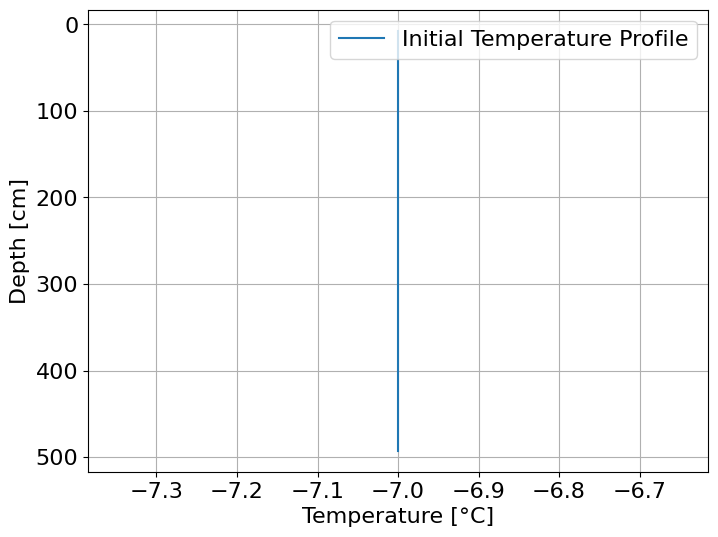

In [98]:
# Setup Spatial Domain
N = int(zs / dz)  # Number of layers
z = np.linspace(dz/2, zs-dz/2, N)  # Depth array in cm

# Initial condition: constant temperature at mean annual air temperature (isothermal)
T_init = np.full(N, Tbottom)  # Assume bottom temperature is the initial temperature

# Plot initial temperature profile
plt.figure(figsize=(8,6))
plt.plot(T_init, z, label='Initial Temperature Profile')
plt.gca().invert_yaxis()  # Invert y-axis so depth increases downwards
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [cm]')
plt.legend()
plt.grid()
plt.show()

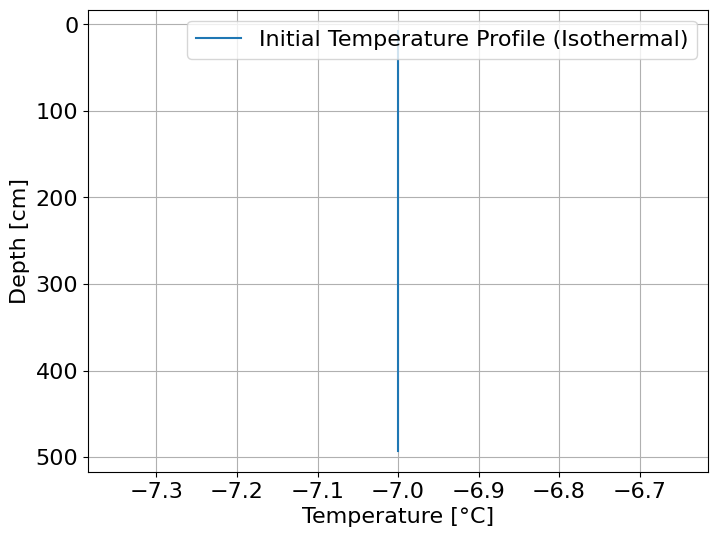

In [99]:
# Initial condition: constant temperature at mean annual air temperature (isothermal)
T_init = np.full(N, Tbottom)  # Initialize entire column with the bottom temperature

# Plot initial temperature profile
plt.figure(figsize=(8,6))
plt.plot(T_init, z, label='Initial Temperature Profile (Isothermal)')
plt.gca().invert_yaxis()  # Invert y-axis so depth increases downwards
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [cm]')
plt.legend()
plt.grid()
plt.show()


In [100]:
# Calculate thermal diffusivity in cm^2/day
alpha = ks / (rhos * Cs) * (86400.0)  # Convert from m^2/s to cm^2/day
print('Thermal diffusivity (alpha) =', alpha, 'cm^2/day')

Thermal diffusivity (alpha) = 0.036973639164669635 cm^2/day


In [101]:
# Spatial domain and Crank-Nicolson parameters
r = alpha * dt / (dz**2)

# Create A and B matrices
A = np.zeros((N, N))
B = np.zeros((N, N))

# Set up A and B matrices
for i in range(1, N-1):
    A[i, i-1] = -r / 2
    A[i, i] = 1 + r
    A[i, i+1] = -r / 2

    B[i, i-1] = r / 2
    B[i, i] = 1 - r
    B[i, i+1] = r / 2

# Boundary conditions
A[0, 0] = 1  # Top boundary
A[-1, -1] = 1  # Bottom boundary

B[0, 0] = 1  # Top boundary (No change for B at boundary)
B[-1, -1] = 1  # Bottom boundary


In [87]:
# Preallocate storage for temperature over time and space
T = np.zeros((Nt, N))  # Nt rows (time), N columns (depth)

# Set the initial condition to the isothermal profile
T[0, :] = T_init

In [102]:
# Time-stepping loop with Crank-Nicolson scheme
for i in np.arange(1, Nt):
    # Apply the surface temperature for the current time step (top boundary condition)
    if i < Nt // 3:
        T[i, 0] = Ttop_15[i]  # Apply 1.5°C scenario in the first third
    elif i < 2 * Nt // 3:
        T[i, 0] = Ttop_30[i - Nt // 3]  # Shift the index for smooth transition in middle third
    else:
        T[i, 0] = Ttop_45[i - 2 * Nt // 3]  # Shift the index for smooth transition in final third

    # Apply the bottom boundary condition (constant temperature)
    T[i, -1] = Tbottom

    # Compute B @ T[i-1, :]
    b = np.dot(B, T[i-1, :])

    # Solve the system to find the new temperature profile
    T_new = np.linalg.solve(A, b)

    # Store the new temperature profile at time step i
    T[i, :] = T_new

    # Print progress (optional)
    #if i % 100 == 0:
        #print(f'Time step {i} of {Nt}')


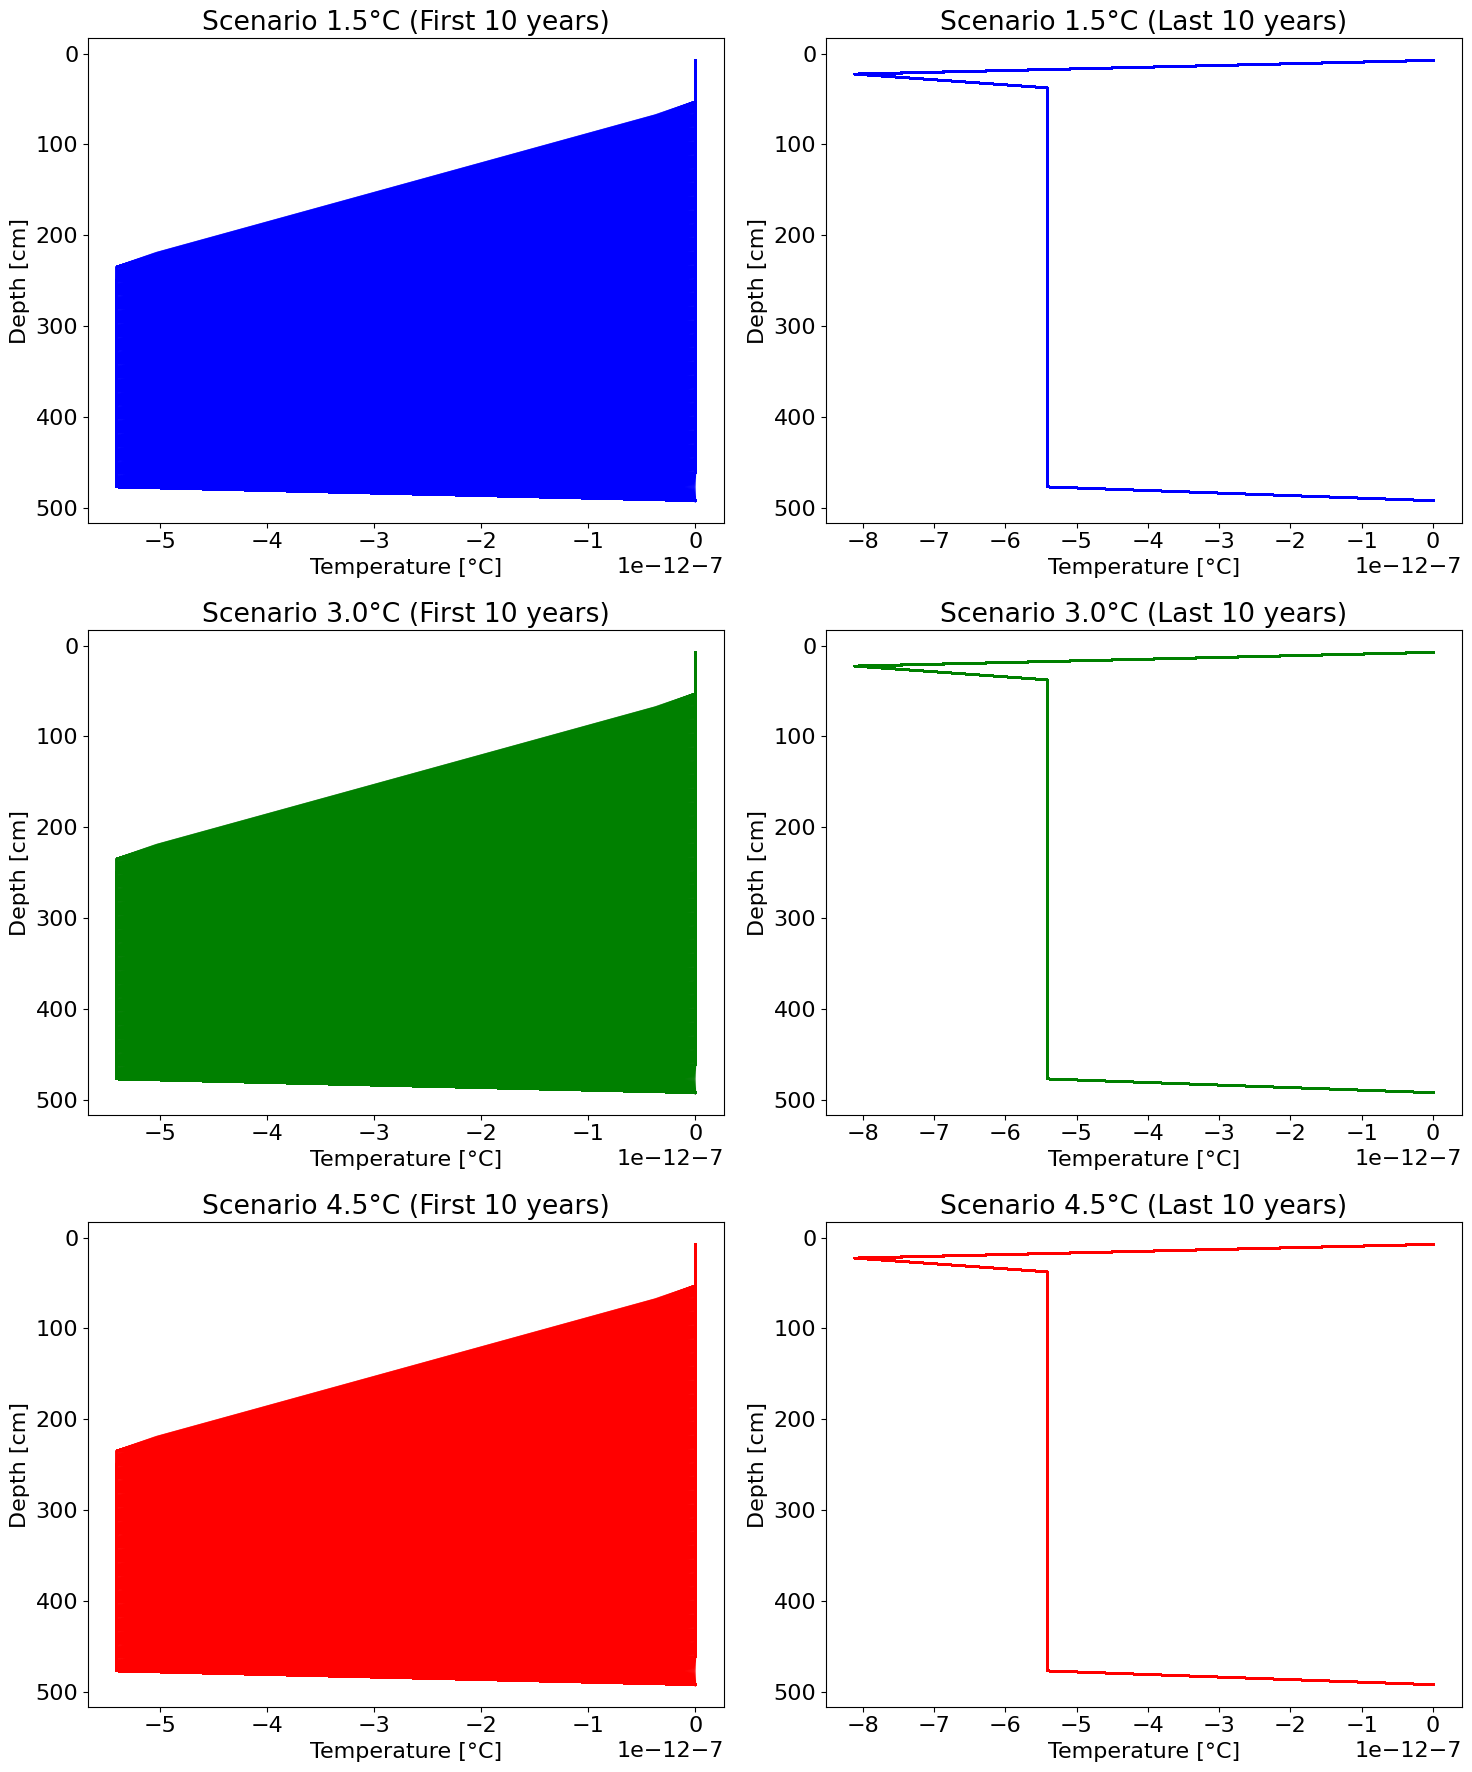

In [103]:
# 3x2 Subplots of the Vertical Temperature Distribution with Time

fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Time index for the first and last 10 years
first_10_years = np.where((t >= t[0]) & (t <= t[0] + 10))[0]
last_10_years = np.where((t >= t[-1] - 10) & (t <= t[-1]))[0]

# Plot for Scenario 1 (Delta T = 1.5°C)
for i in first_10_years:
    axs[0, 0].plot(T[i, :], z, color='blue', alpha=0.1)
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Scenario 1.5°C (First 10 years)')
axs[0, 0].set_xlabel('Temperature [°C]')
axs[0, 0].set_ylabel('Depth [cm]')
for i in last_10_years:
    axs[0, 1].plot(T[i, :], z, color='blue', alpha=0.1)
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Scenario 1.5°C (Last 10 years)')
axs[0, 1].set_xlabel('Temperature [°C]')
axs[0, 1].set_ylabel('Depth [cm]')

# Plot for Scenario 2 (Delta T = 3.0°C)
for i in first_10_years:
    axs[1, 0].plot(T[i, :], z, color='green', alpha=0.1)
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Scenario 3.0°C (First 10 years)')
axs[1, 0].set_xlabel('Temperature [°C]')
axs[1, 0].set_ylabel('Depth [cm]')
for i in last_10_years:
    axs[1, 1].plot(T[i, :], z, color='green', alpha=0.1)
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Scenario 3.0°C (Last 10 years)')
axs[1, 1].set_xlabel('Temperature [°C]')
axs[1, 1].set_ylabel('Depth [cm]')

# Plot for Scenario 3 (Delta T = 4.5°C)
for i in first_10_years:
    axs[2, 0].plot(T[i, :], z, color='red', alpha=0.1)
axs[2, 0].invert_yaxis()
axs[2, 0].set_title('Scenario 4.5°C (First 10 years)')
axs[2, 0].set_xlabel('Temperature [°C]')
axs[2, 0].set_ylabel('Depth [cm]')
for i in last_10_years:
    axs[2, 1].plot(T[i, :], z, color='red', alpha=0.1)
axs[2, 1].invert_yaxis()
axs[2, 1].set_title('Scenario 4.5°C (Last 10 years)')
axs[2, 1].set_xlabel('Temperature [°C]')
axs[2, 1].set_ylabel('Depth [cm]')

plt.tight_layout()
plt.show()


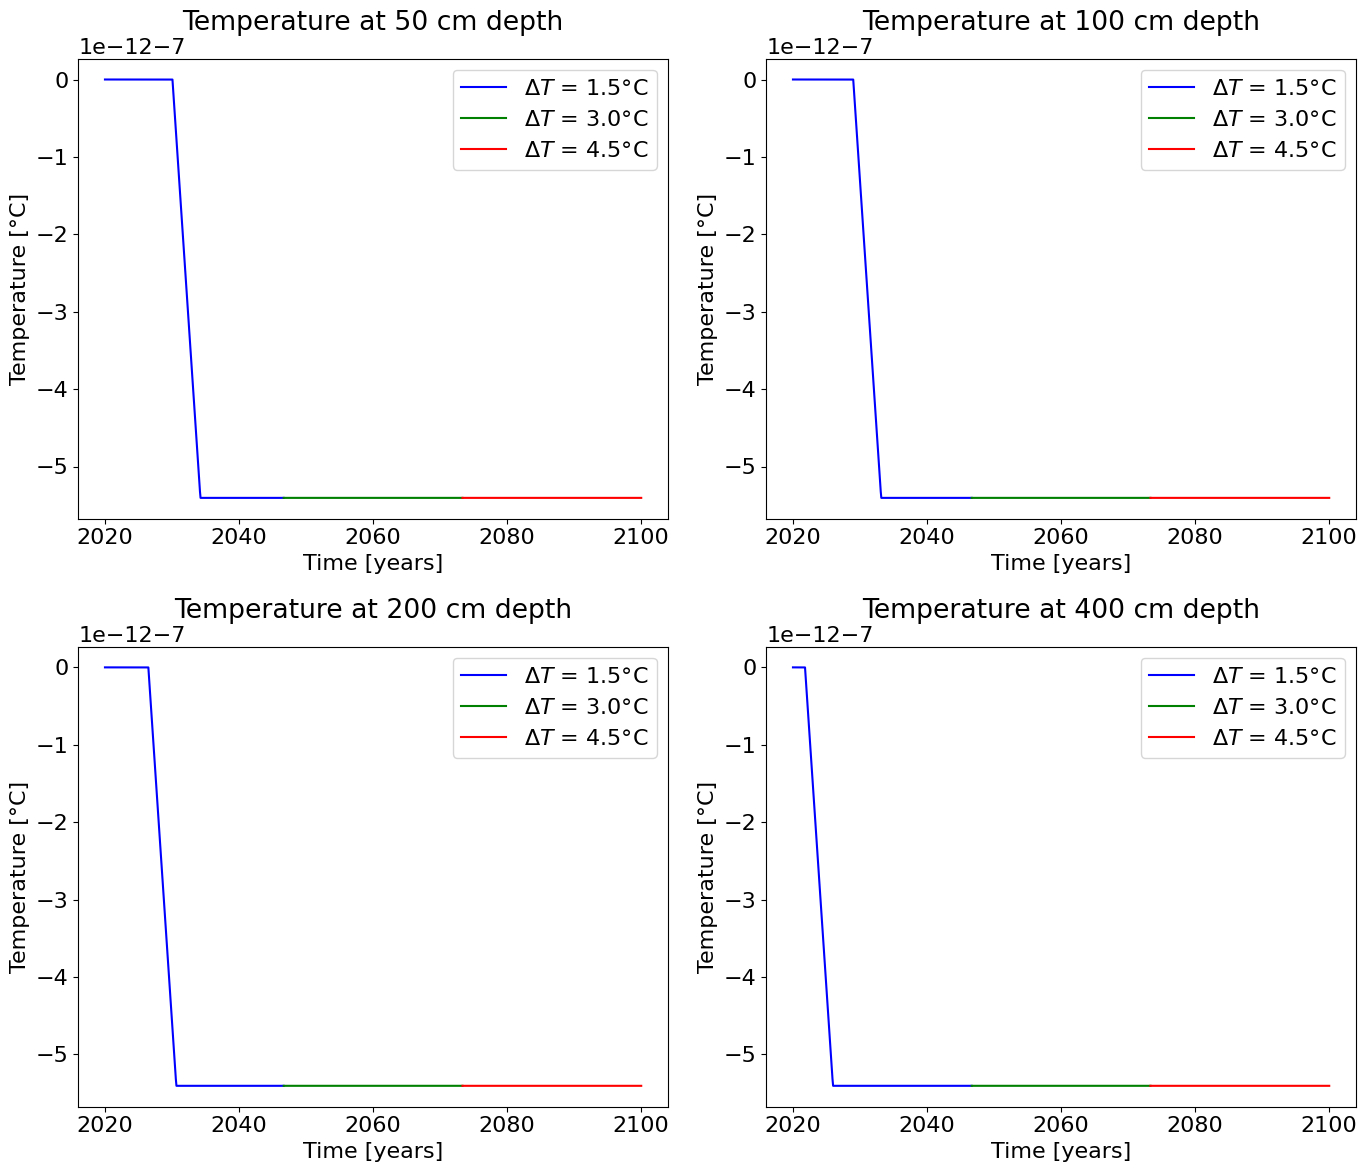

In [106]:
# Define the depths of interest, find their corresponding indices in z array
depths_of_interest = [50, 100, 200, 400]
depth_indices = [np.argmin(np.abs(z - depth)) for depth in depths_of_interest]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Split time and temperature arrays for each scenario
T_scenario_1 = T[:Nt // 3, :]
T_scenario_2 = T[Nt // 3:2 * Nt // 3, :]
T_scenario_3 = T[2 * Nt // 3:, :]

# Time arrays for each scenario
t_scenario_1 = t[:Nt // 3]
t_scenario_2 = t[Nt // 3:2 * Nt // 3]
t_scenario_3 = t[2 * Nt // 3:]

# Plot for 50 cm depth
axs[0, 0].plot(t_scenario_1, T_scenario_1[:, depth_indices[0]], label='$\Delta T$ = 1.5°C', color='blue')
axs[0, 0].plot(t_scenario_2, T_scenario_2[:, depth_indices[0]], label='$\Delta T$ = 3.0°C', color='green')
axs[0, 0].plot(t_scenario_3, T_scenario_3[:, depth_indices[0]], label='$\Delta T$ = 4.5°C', color='red')
axs[0, 0].set_title('Temperature at 50 cm depth')
axs[0, 0].set_xlabel('Time [years]')
axs[0, 0].set_ylabel('Temperature [°C]')
axs[0, 0].legend()

# Plot for 100 cm depth
axs[0, 1].plot(t_scenario_1, T_scenario_1[:, depth_indices[1]], label='$\Delta T$ = 1.5°C', color='blue')
axs[0, 1].plot(t_scenario_2, T_scenario_2[:, depth_indices[1]], label='$\Delta T$ = 3.0°C', color='green')
axs[0, 1].plot(t_scenario_3, T_scenario_3[:, depth_indices[1]], label='$\Delta T$ = 4.5°C', color='red')
axs[0, 1].set_title('Temperature at 100 cm depth')
axs[0, 1].set_xlabel('Time [years]')
axs[0, 1].set_ylabel('Temperature [°C]')
axs[0, 1].legend()

# Plot for 200 cm depth
axs[1, 0].plot(t_scenario_1, T_scenario_1[:, depth_indices[2]], label='$\Delta T$ = 1.5°C', color='blue')
axs[1, 0].plot(t_scenario_2, T_scenario_2[:, depth_indices[2]], label='$\Delta T$ = 3.0°C', color='green')
axs[1, 0].plot(t_scenario_3, T_scenario_3[:, depth_indices[2]], label='$\Delta T$ = 4.5°C', color='red')
axs[1, 0].set_title('Temperature at 200 cm depth')
axs[1, 0].set_xlabel('Time [years]')
axs[1, 0].set_ylabel('Temperature [°C]')
axs[1, 0].legend()

# Plot for 400 cm depth
axs[1, 1].plot(t_scenario_1, T_scenario_1[:, depth_indices[3]], label='$\Delta T$ = 1.5°C', color='blue')
axs[1, 1].plot(t_scenario_2, T_scenario_2[:, depth_indices[3]], label='$\Delta T$ = 3.0°C', color='green')
axs[1, 1].plot(t_scenario_3, T_scenario_3[:, depth_indices[3]], label='$\Delta T$ = 4.5°C', color='red')
axs[1, 1].set_title('Temperature at 400 cm depth')
axs[1, 1].set_xlabel('Time [years]')
axs[1, 1].set_ylabel('Temperature [°C]')
axs[1, 1].legend()

plt.tight_layout()
plt.show()



In [105]:
# Define the temperature threshold for the active layer (typically 0°C)
threshold_temp = 0.0

# Define decades to analyze (first, middle, final)
decades = [first_10_years[-1], Nt // 2, last_10_years[-1]]  # Indices for the end of first, middle, and last decade

# Initialize a dictionary to store active layer depths for each scenario and decade
active_layer_depths = {
    'Scenario 1.5°C': [],
    'Scenario 3.0°C': [],
    'Scenario 4.5°C': []
}

# Find the depth where the temperature is closest to the threshold (0°C) for each scenario and decade
for decade in decades:
    # Scenario 1.5°C
    depth_1_5 = z[np.argmin(np.abs(T[decade, :] - threshold_temp))]
    active_layer_depths['Scenario 1.5°C'].append(depth_1_5)

    # Scenario 3.0°C
    depth_3_0 = z[np.argmin(np.abs(T[decade, :] - threshold_temp))]
    active_layer_depths['Scenario 3.0°C'].append(depth_3_0)

    # Scenario 4.5°C
    depth_4_5 = z[np.argmin(np.abs(T[decade, :] - threshold_temp))]
    active_layer_depths['Scenario 4.5°C'].append(depth_4_5)

# Create a markdown-style table using pandas
import pandas as pd

# Create a DataFrame for the active layer depths
active_layer_df = pd.DataFrame(active_layer_depths, index=['First Decade', 'Middle Decade', 'Final Decade'])

# Print the table
print(active_layer_df)


               Scenario 1.5°C  Scenario 3.0°C  Scenario 4.5°C
First Decade              7.5             7.5             7.5
Middle Decade             7.5             7.5             7.5
Final Decade              7.5             7.5             7.5
